In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
import torch.nn.init as init
import argparse
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision
import math
import matplotlib.pyplot as plt
import os
import numpy as np

# Transformando nossos .jpg em tensores que vão virar nosso conjunto de treino :

In [3]:
# Caminho para a pasta com as imagens
path = "D:/Users/Rodrigo/Downloads/humans3/img_align_celeba/img_align_celeba"

dim = 64

# Transformações para aplicar às imagens
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensiona as imagens para 128x128 pixels
    transforms.ToTensor(), # Converte as imagens em tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza os valores de pixel

])

files_list = os.listdir(path)
train_data_length = len(files_list)

# criando os tensores para armazenar as imagens e rótulos
train_data = torch.zeros(train_data_length, 3, 64, 64) # 3 canais de cores, 64x64 pixels
train_labels = torch.zeros(train_data_length)

# Percorre os arquivos na pasta de imagens
for filename in os.listdir(path):  # os.listdir(data_folder) retorna uma lista com todos arquivos que estão no path 
    if filename.endswith(".jpg"):
        # Carrega a imagem usando o loader padrão
        img_path = os.path.join(path, filename)
        img = default_loader(img_path)

        # Aplica as transformações à imagem
        img = transform(img)

        # Salva a imagem no tensor train_data
        index = files_list.index(filename)
        train_data[index] = img

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

# Cria um DataLoader para carregar os dados em lotes durante o treinamento
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True
    )


In [4]:
# preparando terreno para usarmos GPU quando possível (se não, usaremos CPU)
#device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Cuda')
else:
    device = torch.device("cpu")
    print('No cuda')

# no caso do mac ( meu caso, o device vai ser mps se estiver disponível, se não, cpu)
print(f"PyTorch version: {torch.__version__}")

## Checa se PyTorch tem acesso ao MPS ( coisa de Macbook, ignore se não for seu caso) 
#  MPS = (Metal Performance Shader, Apple's GPU architecture)
#print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
#print(f"Is MPS available? {torch.backends.mps.is_available()}")
#
## Seta o device      
#device = "mps" if torch.backends.mps.is_available() else "cpu"
#print(f"Using device: {device}")

Cuda
PyTorch version: 1.13.1+cu117


# Aqui estão exemplos de imagens que estão no nosso train_set :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

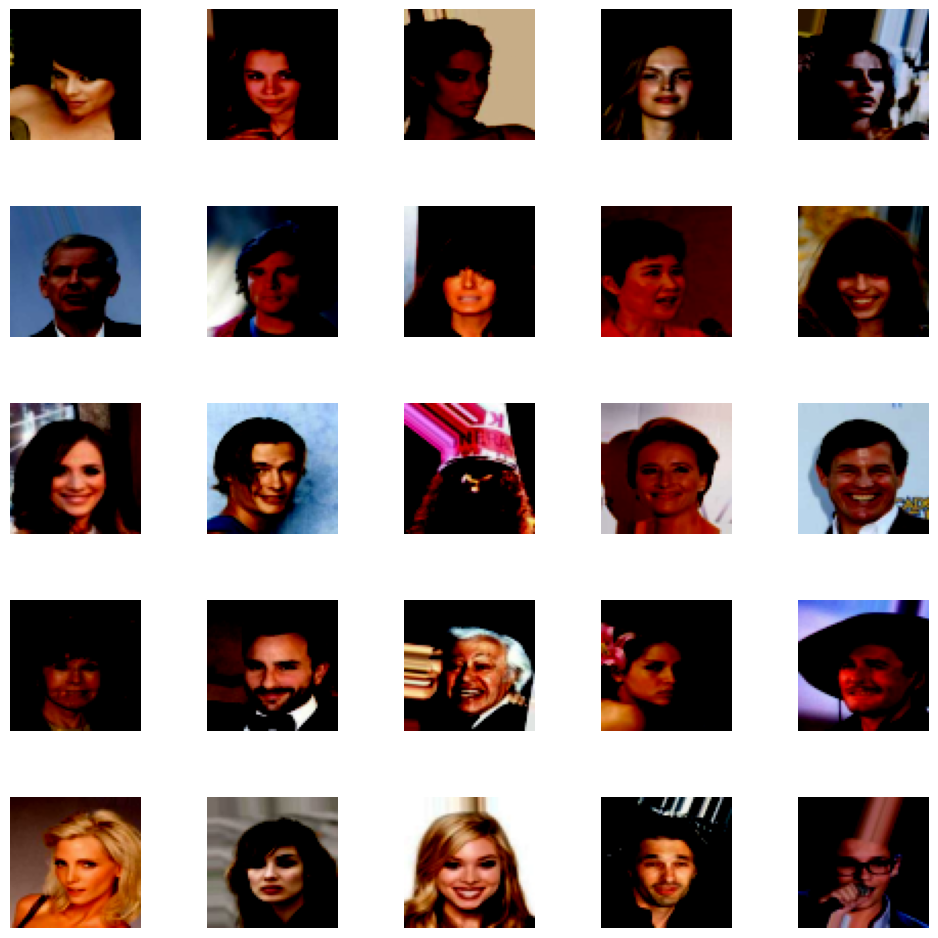

In [5]:
real_samples, labels = next(iter(train_loader))

n = 5
# Exibir as imagens
fig, axs = plt.subplots(n, n, figsize=(10, 10))
fig.tight_layout()

for i in range(n**2):
    row = i // n
    col = i % n
    img = real_samples[i].permute(1, 2, 0)  # Reorganizar as dimensões do tensor
    axs[row, col].imshow(img)
    axs[row, col].axis("off")

plt.show()

# Criando as classes que representam as redes Generativas e Discriminativas

# Tentativa Número 1 , rede neural ingênua com ativações das camadas majoritariamente usando ReLU e na saída do discriminador utilizamos sigmoide, uma vez que queremos valores entre 0 e 1 para determinar a probabilidade de aquilo sendo descriminado estar vindo de uma rede generativa ou de uma outra base de dados qualquer  

In [6]:
class Discriminator(nn.Module):
    """
    Implementa o discriminador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 3*128*128 ( canais de entrada de cor * dimensão * dimensão ) e camada final de tamanho 1
    ( saída binária ) com função de ativação sigmoid.
    
    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x) -> torch.Tensor:
        x = x.view(x.size(0), 3 * 64 * 64)
        output = self.model(x)
        return output
    

discriminator = Discriminator().to(device=device)

In [7]:
class Generator(nn.Module):
    """
    Implementa o gerador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 100 ( tamanho do vetor de entrada ) e camada final de tamanho 3*128*128 
    ( canais de saída de cor * dimensão * dimensão )

    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh(),
        )

    def forward(self, x) -> torch.Tensor:
        output = self.model(x)
        output = output.view(x.size(0), 3, 64, 64)
        return output

generator = Generator().to(device=device)

In [8]:
lr = 0.0001 # learning rating 
num_epochs = 50 # número de épocas ( iterações )
loss_function = nn.BCELoss() # função de perda ( binary cross entropy loss )

# Otimizadores para o gerador e o discriminador, seguindo o algoritmo Adam
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [9]:
import os
from PIL import Image

# Defina o diretório onde as imagens geradas serão salvas
output_dir = 'D:/Users/Rodrigo/Documents/UFRJ/2023.1 (BCC)/ML/outputs_p2p_200k'

# Verifique se o diretório de saída existe, caso contrário, crie-o
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

k = 5  # Intervalo para avaliação do discriminador
discriminator_critique = True  # Variável para controlar se o discriminador deve fazer uma crítica

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device=device)
        batch_size = real_samples.shape[0]  # Obter o tamanho atual do lote
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        all_samples = torch.cat((real_samples, generated_samples))

        # Treinamento do discriminador
        if discriminator_critique:
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

        # Dados para o treinamento do gerador
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Treinamento do gerador
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Exibir as perdas
        if n == len(train_loader) - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Gerar imagens a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        # Criar uma pasta para a época atual
        epoch_dir = os.path.join(output_dir, f"epoch_{epoch + 1}")
        if not os.path.exists(epoch_dir):
            os.makedirs(epoch_dir)

        # Gerar e salvar as imagens
        with torch.no_grad():
            latent_space_samples = torch.randn((10, 100)).to(device=device)
            generated_samples = generator(latent_space_samples).detach().cpu()

        for i in range(10):
            image = generated_samples[i].permute(1, 2, 0)
            image = (image + 1) / 2
            image = image.clamp(0, 1)  # Garantir que os valores estejam entre 0 e 1
            image = np.array(image.detach().cpu())  # Converter para numpy array
            image = np.uint8(image * 255)  # Converter para valores inteiros entre 0 e 255
            save_path = os.path.join(epoch_dir, f"sample_{i + 1}.png")
            image = Image.fromarray(image)
            image.save(save_path)

Epoch: 0 Loss D.: 0.046235136687755585
Epoch: 0 Loss G.: 5.252233505249023
Epoch: 1 Loss D.: 0.16240495443344116
Epoch: 1 Loss G.: 4.1669206619262695
Epoch: 2 Loss D.: 0.273720920085907
Epoch: 2 Loss G.: 2.5004184246063232
Epoch: 3 Loss D.: 0.464286208152771
Epoch: 3 Loss G.: 2.908644676208496
Epoch: 4 Loss D.: 0.3503592908382416
Epoch: 4 Loss G.: 1.937760829925537
Epoch: 5 Loss D.: 0.8315721750259399
Epoch: 5 Loss G.: 1.2648435831069946
Epoch: 6 Loss D.: 0.462836354970932
Epoch: 6 Loss G.: 0.945876955986023
Epoch: 7 Loss D.: 0.42555296421051025
Epoch: 7 Loss G.: 0.9663203358650208
Epoch: 8 Loss D.: 0.6026848554611206
Epoch: 8 Loss G.: 1.079308271408081
Epoch: 9 Loss D.: 0.4811791181564331
Epoch: 9 Loss G.: 0.9919357895851135
Epoch: 10 Loss D.: 0.4707050323486328
Epoch: 10 Loss G.: 1.0977835655212402
Epoch: 11 Loss D.: 0.7185357213020325
Epoch: 11 Loss G.: 1.0828337669372559
Epoch: 12 Loss D.: 0.613783597946167
Epoch: 12 Loss G.: 1.1166269779205322
Epoch: 13 Loss D.: 0.5115693211555481

# Agora iremos fazer nossa tentativa 2 e adicionar algumas mudanças, pesquisamos a fundo e descobrimos que leakyReLU pode ter um resultado melhor no nosso código, então vamos mudar nossas funções de ativação, e outra técnica mais avançada que costumam usar é criar ciclos para o discriminador agir, ele só vai criticar de k em k épocas, então farei isso, vou incluir essa técnica no nosso modelo

In [15]:
dimensao = 64
numero_de_pixels = dimensao * dimensao

#help
class Discriminator(nn.Module):
    """
    Implementa o discriminador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 3*128*128 ( canais de entrada de cor * dimensão * dimensão ) e camada final de tamanho 1
    ( saída binária ) com função de ativação sigmoid.

    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x) -> torch.Tensor:
        x = x.view(x.size(0), 3 * 64 * 64)
        output = self.model(x)
        return output



discriminator = Discriminator().to(device=device)

In [16]:
class Generator(nn.Module):
    """
    Implementa o gerador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 100 ( tamanho do vetor de entrada ) e camada final de tamanho 3*128*128 
    ( canais de saída de cor * dimensão * dimensão )

    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),  # Adicionando LeakyReLU com negative_slope de 0.2
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh(),
        )

    def forward(self, x) -> torch.Tensor:
        output = self.model(x)
        output = output.view(x.size(0), 3, 64, 64)
        return output

generator = Generator().to(device=device)


# Escolhendo os parâmetros de treinamento

In [17]:
lr = 0.0001  # Learning rate
num_epochs = 50 # Número de épocas
loss_function = nn.BCELoss()  # Função de perda (Binary Cross Entropy Loss)

# Otimizadores para o gerador e o discriminador, seguindo o algoritmo Adam
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))


In [18]:
import os
from PIL import Image

# Defina o diretório onde as imagens geradas serão salvas
output_dir = 'D:/Users/Rodrigo/Documents/UFRJ/2023.1 (BCC)/ML/outputs_p2p_200k_2'

# Verifique se o diretório de saída existe, caso contrário, crie-o
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

k = 5  # Intervalo para avaliação do discriminador
discriminator_critique = True  # Variável para controlar se o discriminador deve fazer uma crítica

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device=device)
        batch_size = real_samples.shape[0]  # Obter o tamanho atual do lote
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        all_samples = torch.cat((real_samples, generated_samples))

        # Treinamento do discriminador
        if discriminator_critique:
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

        # Dados para o treinamento do gerador
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Treinamento do gerador
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Exibir as perdas
        if n == len(train_loader) - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Gerar imagens a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        # Criar uma pasta para a época atual
        epoch_dir = os.path.join(output_dir, f"epoch_{epoch + 1}")
        if not os.path.exists(epoch_dir):
            os.makedirs(epoch_dir)

        # Gerar e salvar as imagens
        with torch.no_grad():
            latent_space_samples = torch.randn((10, 100)).to(device=device)
            generated_samples = generator(latent_space_samples).detach().cpu()

        for i in range(10):
            image = generated_samples[i].permute(1, 2, 0)
            image = (image + 1) / 2
            image = image.clamp(0, 1)  # Garantir que os valores estejam entre 0 e 1
            image = np.array(image.detach().cpu())  # Converter para numpy array
            image = np.uint8(image * 255)  # Converter para valores inteiros entre 0 e 255
            save_path = os.path.join(epoch_dir, f"sample_{i + 1}.png")
            image = Image.fromarray(image)
            image.save(save_path)

Epoch: 0 Loss D.: 0.4723532795906067
Epoch: 0 Loss G.: 0.9114041328430176
Epoch: 1 Loss D.: 0.5704088807106018
Epoch: 1 Loss G.: 0.8248664140701294
Epoch: 2 Loss D.: 0.6104276776313782
Epoch: 2 Loss G.: 0.7612128853797913
Epoch: 3 Loss D.: 0.5896152257919312
Epoch: 3 Loss G.: 0.5809277296066284
Epoch: 4 Loss D.: 0.6106510162353516
Epoch: 4 Loss G.: 0.8250885605812073
Epoch: 5 Loss D.: 0.6657535433769226
Epoch: 5 Loss G.: 0.6079826354980469
Epoch: 6 Loss D.: 0.598500669002533
Epoch: 6 Loss G.: 0.7976996898651123
Epoch: 7 Loss D.: 0.6604416966438293
Epoch: 7 Loss G.: 0.6786181330680847
Epoch: 8 Loss D.: 0.7481808066368103
Epoch: 8 Loss G.: 0.7697826623916626
Epoch: 9 Loss D.: 0.7472153306007385
Epoch: 9 Loss G.: 0.6893059611320496
Epoch: 10 Loss D.: 0.7887972593307495
Epoch: 10 Loss G.: 0.6857868432998657
Epoch: 11 Loss D.: 0.6815676093101501
Epoch: 11 Loss G.: 0.6963707208633423
Epoch: 12 Loss D.: 0.6450769305229187
Epoch: 12 Loss G.: 0.8233927488327026
Epoch: 13 Loss D.: 0.701302826404

# Adicionando Convolução

In [19]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [20]:
# Root directory for dataset
dataroot = "D:/Users/Rodrigo/Downloads/humans3/img_align_celeba"

# Output directory for results
output_dir = "D:/Users/Rodrigo/Documents/UFRJ/2023.1 (BCC)/ML/outputs_conv_200k"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 25

# Size of feature maps in discriminator
ndf = 25

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

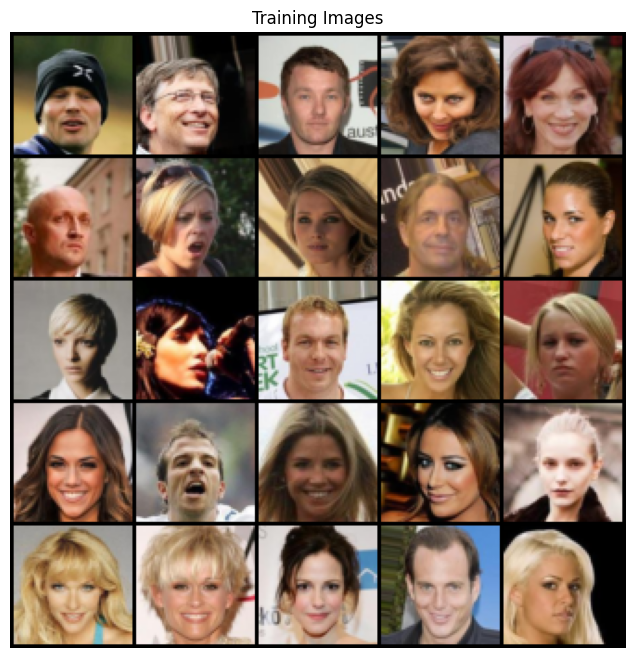

In [21]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:25], nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
# custom weights initialization called on ``netG`` and ``netD``

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [23]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [24]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 200, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(200, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(100, 50, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(50, 25, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(25, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [25]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [26]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 25, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(25, 50, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(50, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(100, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(200, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [27]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [28]:
def img_saver( im, epoch, dir ):
    image = im.permute(1, 2, 0)
    image = (image + 1) / 2
    image = np.array(image.detach().cpu())
    image = np.uint8(image * 510)
    save_path = os.path.join(dir, f'sample_{epoch}.png')
    image = Image.fromarray(image)
    image.save(save_path)

In [29]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

k = 5

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake

        # Update D only when the condition is met
        if i % k == 0:
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, nrow=5, normalize=True))

        iters += 1
    img_saver(img_list[-1], epoch+1, output_dir)
    if (epoch + 1) % 10 == 0:
        epoch_dir = os.path.join(output_dir, f'epoch_{epoch+1}')
        if not os.path.exists(epoch_dir): os.makedirs(epoch_dir)
        for i in range( 10 ):
            ith_noise = torch.randn(1, nz, 1, 1, device=device)
            aux = netG(ith_noise).detach().cpu()
            img_saver( vutils.make_grid(aux, padding=2, nrow=5, normalize=True), i+1, epoch_dir )

Starting Training Loop...
[0/50][0/1583]	Loss_D: 1.7710	Loss_G: 1.4067	D(x): 0.4215	D(G(z)): 0.5397 / 0.2732
[0/50][50/1583]	Loss_D: 4.9627	Loss_G: 0.7671	D(x): 0.6438	D(G(z)): 0.9859 / 0.4753
[0/50][100/1583]	Loss_D: 4.7468	Loss_G: 1.4666	D(x): 0.5951	D(G(z)): 0.9794 / 0.2378
[0/50][150/1583]	Loss_D: 4.6539	Loss_G: 2.0686	D(x): 0.4357	D(G(z)): 0.9680 / 0.1302
[0/50][200/1583]	Loss_D: 5.7125	Loss_G: 1.3168	D(x): 0.2525	D(G(z)): 0.9762 / 0.2729
[0/50][250/1583]	Loss_D: 5.0433	Loss_G: 1.8866	D(x): 0.2500	D(G(z)): 0.9549 / 0.1551
[0/50][300/1583]	Loss_D: 4.8187	Loss_G: 1.8781	D(x): 0.2496	D(G(z)): 0.9409 / 0.1545
[0/50][350/1583]	Loss_D: 4.4247	Loss_G: 2.2982	D(x): 0.2631	D(G(z)): 0.9198 / 0.1033
[0/50][400/1583]	Loss_D: 4.3155	Loss_G: 2.0683	D(x): 0.1877	D(G(z)): 0.8857 / 0.1302
[0/50][450/1583]	Loss_D: 3.3883	Loss_G: 2.1909	D(x): 0.3236	D(G(z)): 0.8332 / 0.1130
[0/50][500/1583]	Loss_D: 3.3422	Loss_G: 2.1202	D(x): 0.3151	D(G(z)): 0.8217 / 0.1214
[0/50][550/1583]	Loss_D: 2.6414	Loss_G: 2.

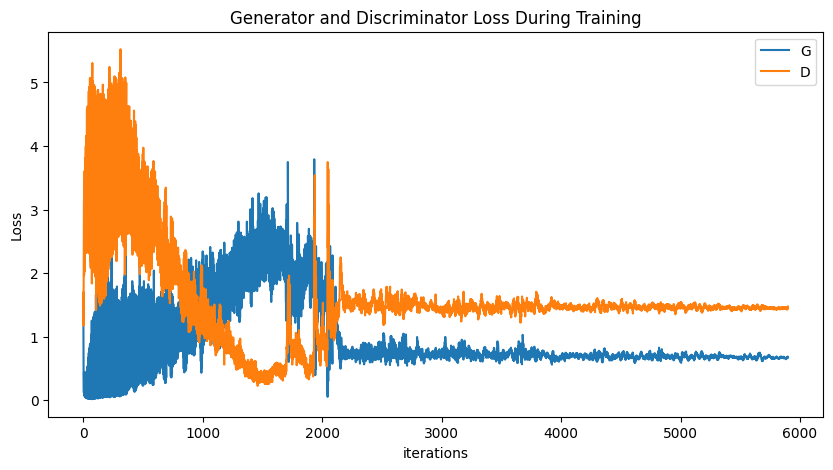

In [81]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

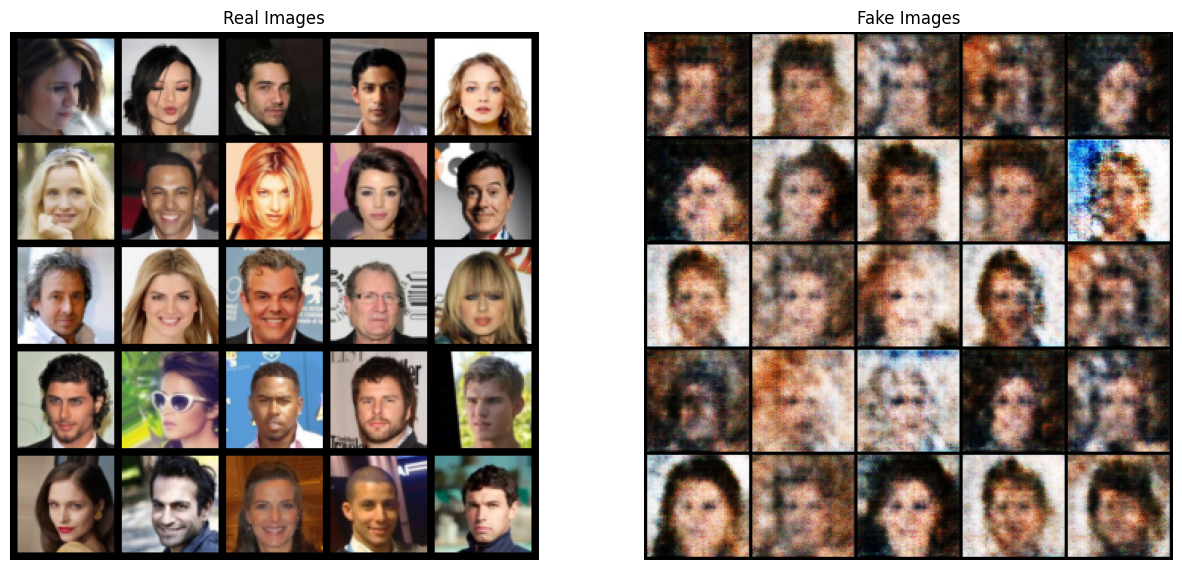

In [84]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:25], nrow=5, padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [29]:
from PIL import Image
def img_saver( im_list ):
    for i, image in enumerate(im_list):
        image = im_list[i].permute(1, 2, 0)
        image = (image + 1) / 2
        image = image.clamp(0, 1)
        image = np.array(image.detach().cpu())
        image = np.uint8(image * 255)
        save_path = os.path.join( 'test-results', f'{i}.png')
        image = Image.fromarray(image)
        image.save(save_path)

In [30]:
img_saver(img_list)